# Entanglement by measurement on Starmon-5 -- Analysis

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import itertools as it

import qiskit.tools.jupyter
import qiskit.tools.visualization as qvis # circuit_drawer, plot_histogram

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, get_starmon_status, inspire_login, get_file_header, measure_readout_correction
from inspire_experiments.analysis_tools import *

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%load_ext autoreload
%autoreload 2
%qiskit_version_table

In [2]:
api, backend = inspire_login()
backend.status()

Backend status:  IDLE


In [3]:

get_starmon_status(api)

'IDLE'

## Entaglement by msmt


### Readout correction

In [11]:
# qubits = [1, 2, 3]
# tomo_qubits = [1, 3]
qubits = [0, 2, 4]
tomo_qubits = [0, 4]
# qubits = [1, 2, 4]
# tomo_qubits = [1, 4]
sim_msmt = False
exp_name = "entanglement_by_msmt_qbs"
extra_label = "_Xqb0"

exp_name += str(qubits)
exp_name += "_sim-msmt" if sim_msmt else ''
# exp_name += "_XY4" if not sim_msmt else ''
exp_name += extra_label if extra_label else ''
exp_name += f"_tom{tomo_qubits}"
# exp_name = exp_name + "_sim-msmt" if sim_msmt else exp_name
print(exp_name)

entanglement_by_msmt_qbs[0, 2, 4]_Xqb0_tom[0, 4]


In [5]:
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=2)]:
    print(state)
    bitstrings = ExperimentData.get_csv_data(f"readout_correction_qbs{tomo_qubits}{extra_label}_state{state}_RAW.csv", use_string_repr=True)
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = 1 - 2*np.array(list(map(lambda s: s[-1-qb], bitstrings)), dtype=int)
shots_dict

00
array(['00000', '00000', '00000', ..., '00000', '00000', '00000'],
      dtype='<U5')
01
array(['10000', '10000', '10000', ..., '10000', '10000', '10000'],
      dtype='<U5')
10
array(['00000', '00001', '00001', ..., '00001', '00001', '00001'],
      dtype='<U5')
11
array(['10001', '10001', '10001', ..., '10001', '10001', '10001'],
      dtype='<U5')


{0: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([1, 1, 1, ..., 1, 1, 1]),
  '10': array([ 1, -1, -1, ..., -1, -1, -1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])},
 4: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([-1, -1, -1, ..., -1, -1, -1]),
  '10': array([1, 1, 1, ..., 1, 1, 1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])}}

In [6]:
(shots_dict[tomo_qubits[0]]['11'] == shots_dict[tomo_qubits[1]]['11']).all()

False

In [7]:
beta = get_beta_matrix(shots_dict, 2)
beta

{'IZ': array([ 0.02038574,  0.94067383, -0.00439453,  0.00354004]),
 'ZI': array([-0.00109863,  0.00762939,  0.90600586,  0.00750732]),
 'ZZ': array([6.10351562e-03, 1.83105469e-04, 2.58789062e-02, 8.52233887e-01])}

### Tomography data

In [8]:
print(gen_gate_order(2))

['ZZ' 'XZ' 'YZ' 'ZX' 'XX' 'YX' 'ZY' 'XY' 'YY']


In [9]:
qubits

[0, 2, 4]

In [21]:
data_hex = np.loadtxt("./data/" + exp_name + f"_M{('Z','Z')}" + "_RAW.csv", comments='#', dtype=str, delimiter=',')
data_hex

array(['0x1', '0x4', '0x1', ..., '0x1', '0x1', '0x5'], dtype='<U4')

In [14]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(2)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)

tomo_shots_dict = {qb: {} for qb in tomo_qubits}

for i, tomo_state in enumerate(gate_order):
    # print(tomo_state)
    filename = exp_name + f"_M{tuple(tomo_state)}"
    print(filename)
    bitstrings = ExperimentData.get_csv_data(filename + "_RAW.csv", use_string_repr=False)
    print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    masks_0[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 0, 1, np.nan)
    masks_1[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

entanglement_by_msmt_qbs[0, 2, 4]_Xqb0_tom[0, 4]_M('Z', 'Z')
[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 1]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 1]]


IndexError: invalid index to scalar variable.

In [22]:
ExperimentData.timestamp


'Wed Aug 24 01:15:01 2022'

### Results

In [ ]:
expvals_0, rho_0, p_frac0 = get_pauli_expectation_values(tomo_shots_dict, beta, gate_order, masks_0)
expvals_1, rho_1, p_frac1 = get_pauli_expectation_values(tomo_shots_dict, beta, gate_order, masks_1)

In [144]:
np.abs(rho_1)

array([[0.03043165, 0.01564134, 0.02391788, 0.00847606],
       [0.01564134, 0.44599813, 0.40372941, 0.01467569],
       [0.02391788, 0.40372941, 0.47802693, 0.01853449],
       [0.00847606, 0.01467569, 0.01853449, 0.04554329]])

In [145]:
np.allclose(list(map(np.trace, [rho_1, rho_0])), 1.0)

True

In [146]:
np.abs(rho_1) <= 0.5

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [147]:
np.mean(list(p_frac1.values()))

0.48946380615234375

### Plotting

In [148]:
zero = np.array([1,0])
one = np.array([0,1])
# A = np.kron(zero, zero)/np.sqrt(2)
# B = np.kron(one, one)/np.sqrt(2)
A = np.kron(zero, one)/np.sqrt(2)
B = np.kron(one, zero)/np.sqrt(2)
np.outer(A-B, A-B)


array([[ 0. ,  0. , -0. ,  0. ],
       [ 0. ,  0.5, -0.5,  0. ],
       [-0. , -0.5,  0.5, -0. ],
       [ 0. ,  0. , -0. ,  0. ]])

19:45:34 - inspire_experiments.data_utils:INFO - Saving figure <entanglement_by_msmt_qbs[0, 2, 4]_Xqb0_tom[0, 4] - Figure(1800x1600)> in ./plots/


0.8672754747955008 0.8650950281087504


/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:129: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
19:45:34 - inspire_experiments.data_utils:INFO - Saving figure <entanglement_by_msmt_qbs[0, 2, 4]_Xqb0_tom[0, 4]_EXPVALS - Figure(1260x720)> in ./plots/


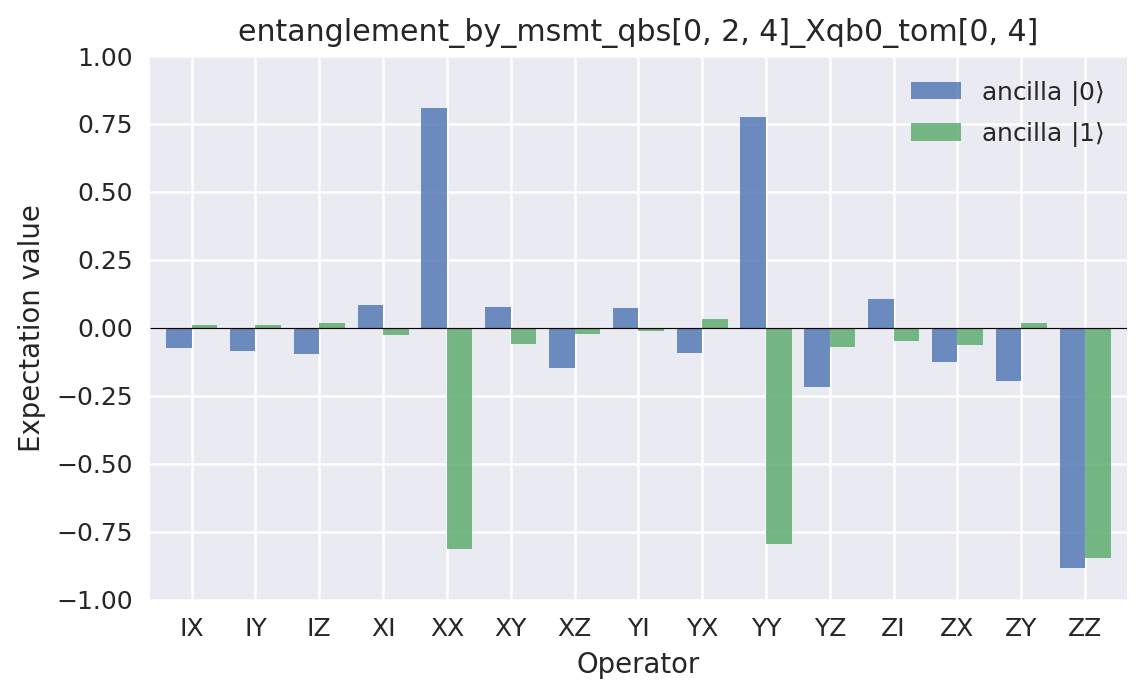

/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


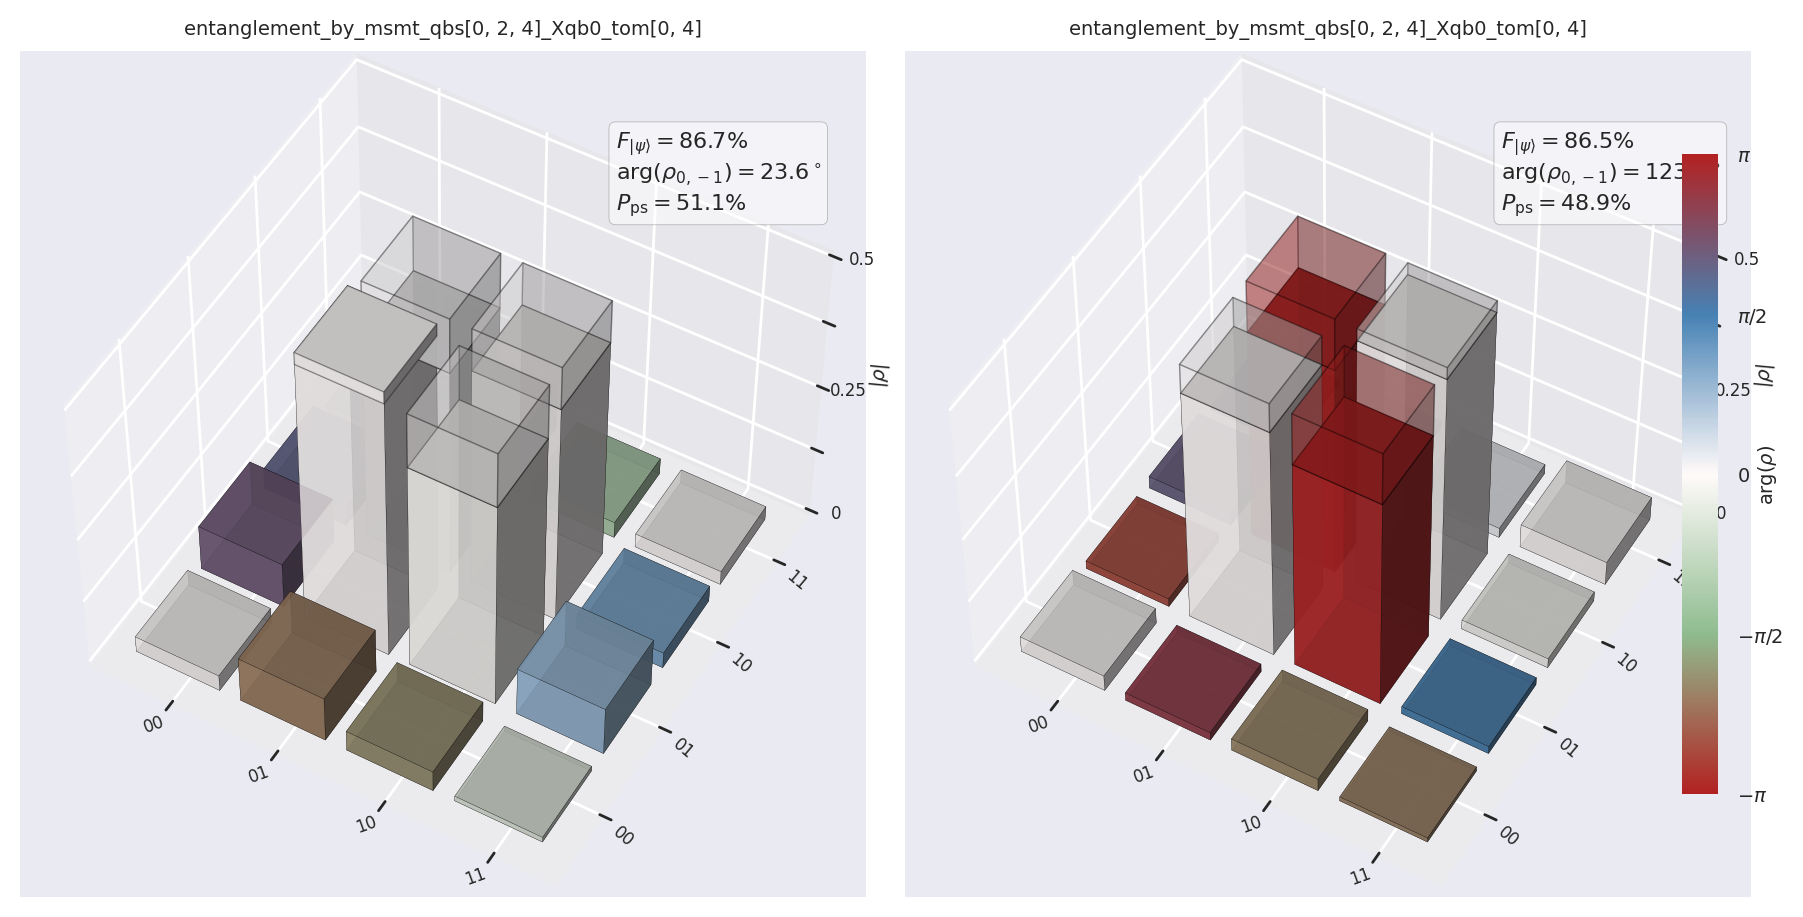

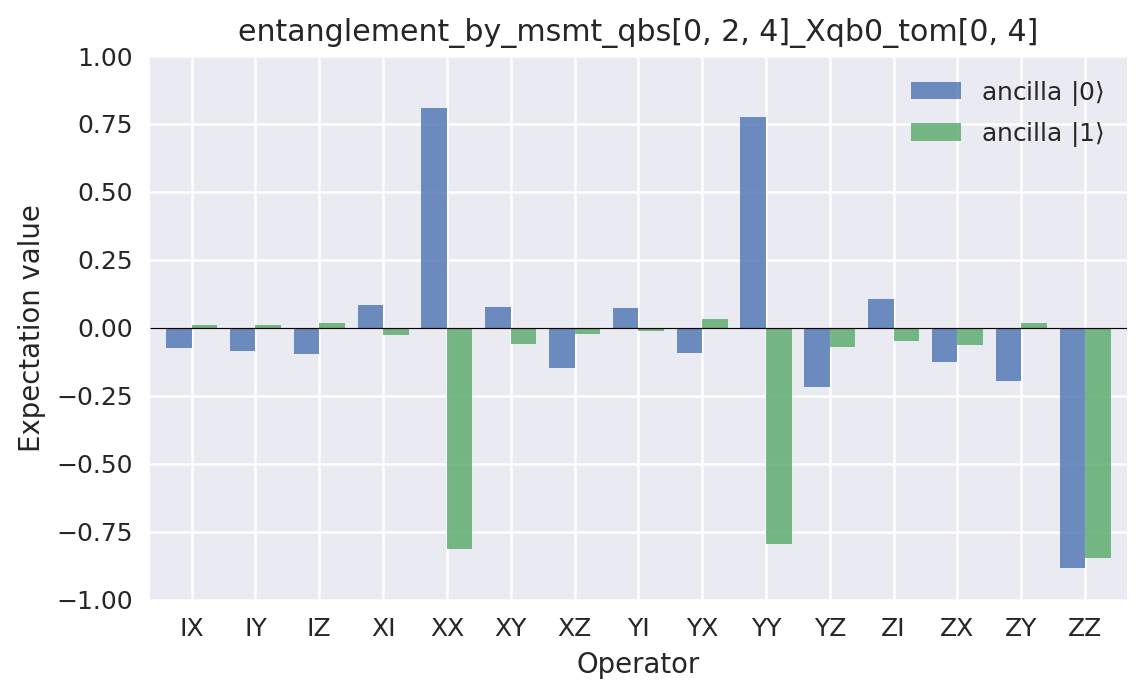

In [149]:
# rho_model_0 = np.zeros(rho_0.shape)
# rho_model_0[ 0, 0] = 0.5
# rho_model_0[ 0,-1] = 0.5
# rho_model_0[-1, 0] = 0.5
# rho_model_0[-1,-1] = 0.5

rho_model_0 = np.outer(A+B,A+B)
rho_model_1 = np.outer(A-B,A-B)

fid_0 = fidelity(rho_0, rho_model_0)
fid_1 = fidelity(rho_1, rho_model_1)
angle_0 = np.angle(rho_0[0,-1], deg=True)
angle_1 = np.angle(rho_1[0,-1], deg=True)
print(fid_0, fid_1)

fig = plot_density_matrix(rho=rho_0, rho_id=rho_model_0, angle=angle_0, fidelity=fid_0, ps_frac=np.mean(list(p_frac0.values())), title=exp_name,
  rho2=rho_1, rho2_id=rho_model_1, angle2=angle_1, fidelity2=fid_1, ps_frac2=np.mean(list(p_frac1.values())), title2=exp_name,
                          camera_azim=-60, camera_elev=50)
ExperimentData.save_fig(fig, exp_name)

df = pd.DataFrame({r'ancilla $|0\rangle$': expvals_0, r'ancilla $|1\rangle$': expvals_1}).sort_index()
fig2, _ = plot_pauli_exp_values(df[1:], title=exp_name)
ExperimentData.save_fig(fig2, exp_name + "_EXPVALS")

In [55]:
rho_model_0

array([[ 0.5,  0. ,  0. , -0.5],
       [ 0. ,  0. ,  0. , -0. ],
       [ 0. ,  0. ,  0. , -0. ],
       [-0.5, -0. , -0. ,  0.5]])

In [59]:
df

,ancilla $|0\rangle$,ancilla $|1\rangle$
II,1.000000,1.000000
IX,0.126815,0.171036
IY,0.137407,0.182703
IZ,0.147536,0.176699
XI,0.030347,0.046834
XX,0.486204,0.266391
XY,0.248895,-0.278161
XZ,-0.042944,0.039356
YI,0.017286,0.002440
YX,0.277601,-0.293088


/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


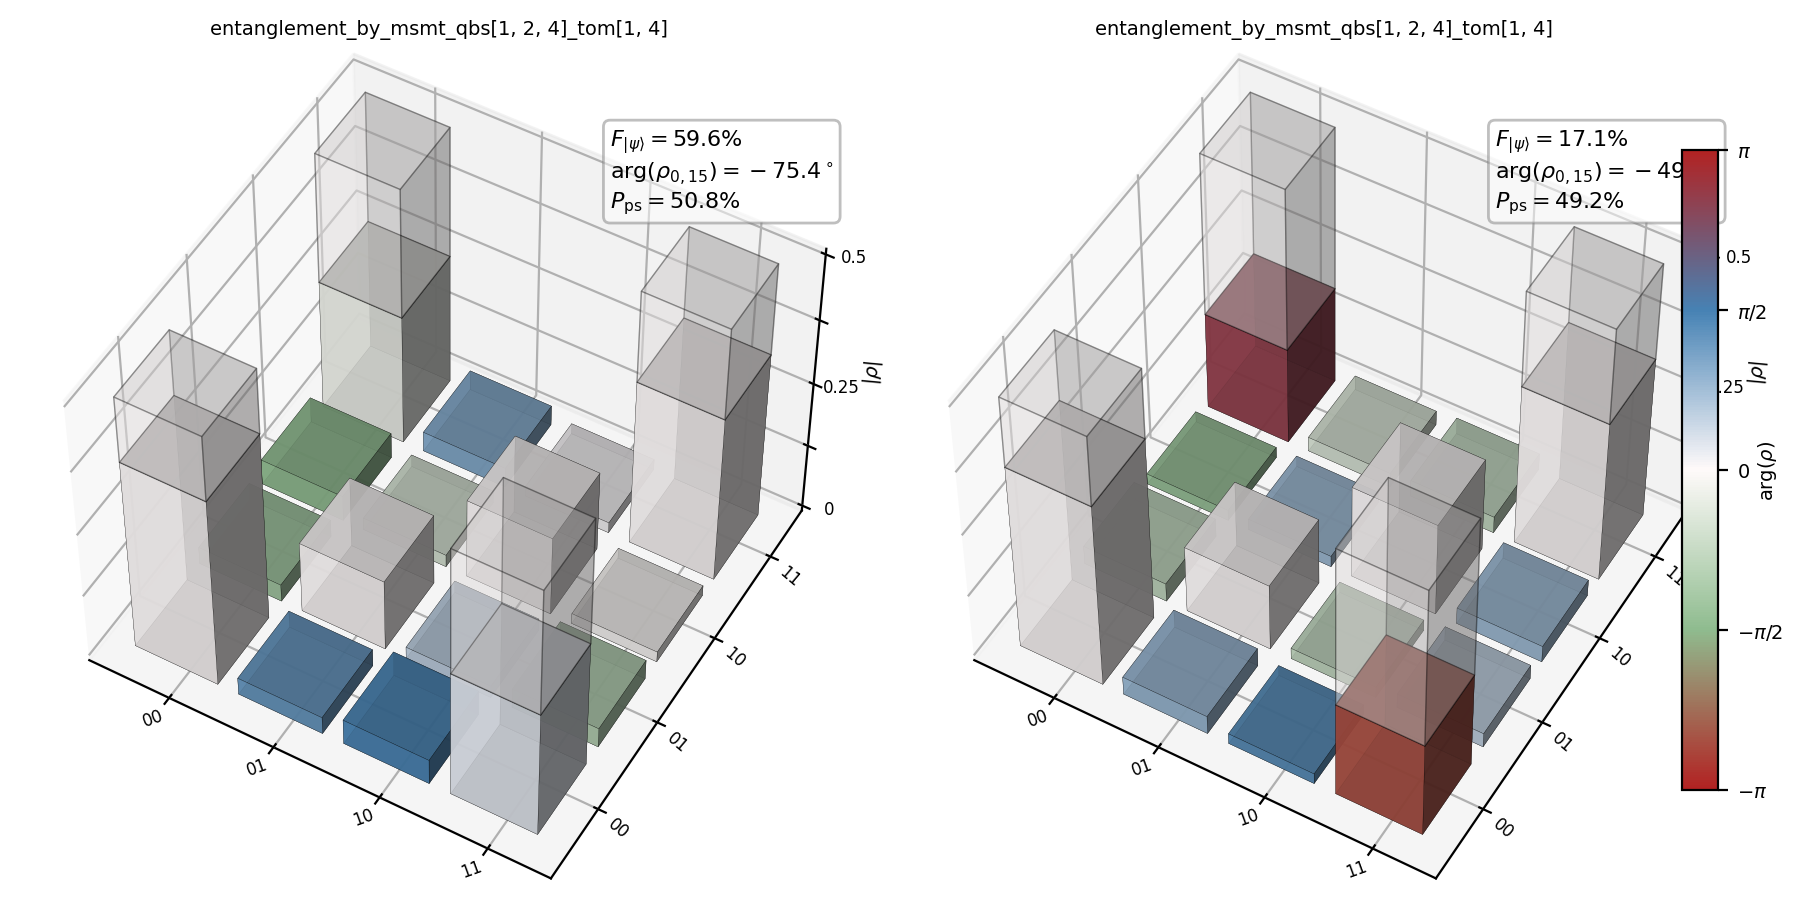

In [35]:
rho_model = np.zeros(rho_0.shape)
rho_model[ 0, 0] = 0.5
rho_model[ 0,-1] = 0.5
rho_model[-1, 0] = 0.5
rho_model[-1,-1] = 0.5
fid_0 = fidelity(rho_0, rho_model)
fid_1 = fidelity(rho_1, rho_model.conj())
angle_0 = np.angle(rho_0[0,1], deg=True)
angle_1 = np.angle(rho_1[0,1], deg=True)

fig = plot_density_matrix(rho=rho_0, rho_id=rho_model, angle=angle_0, fidelity=fid_0, ps_frac=np.mean(list(p_frac0.values())), title=exp_name,
  rho2=rho_1, rho2_id=rho_model.conj(), angle2=angle_1, fidelity2=fid_1, ps_frac2=np.mean(list(p_frac1.values())), title2=exp_name,
                          camera_azim=-60, camera_elev=50)
# ExperimentData.save_fig(fig, exp_name)

In [56]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_0)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

0.04249933982823206 0.11765491831351751 142.68604978580146 -173.9182682572741 0.4988670349121094 0.5011329650878906


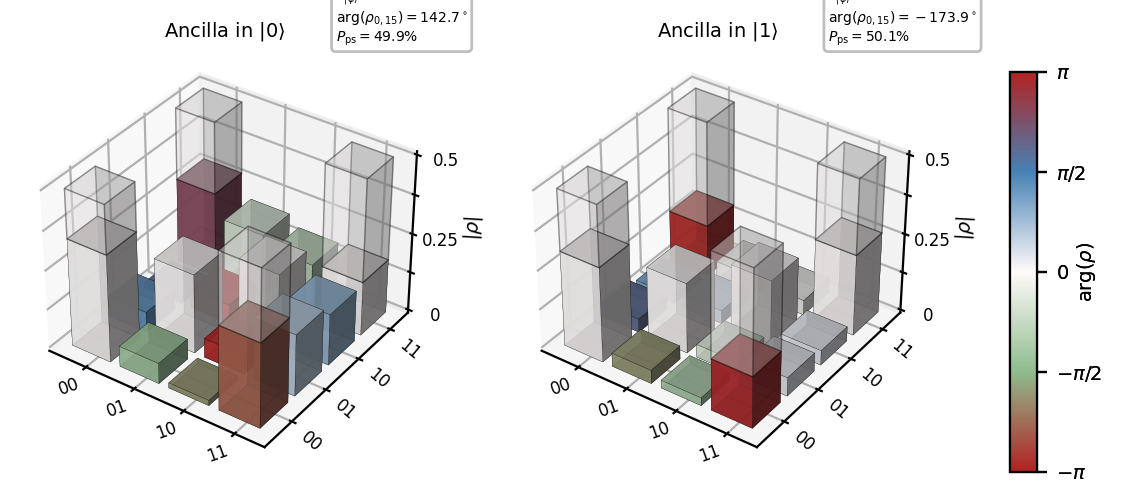

In [57]:
fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=35)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_0, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

0.5706187552933286 0.12420473253336199 -20.312301688053957 0.369108593503929 0.5069007873535156 0.4930992126464844


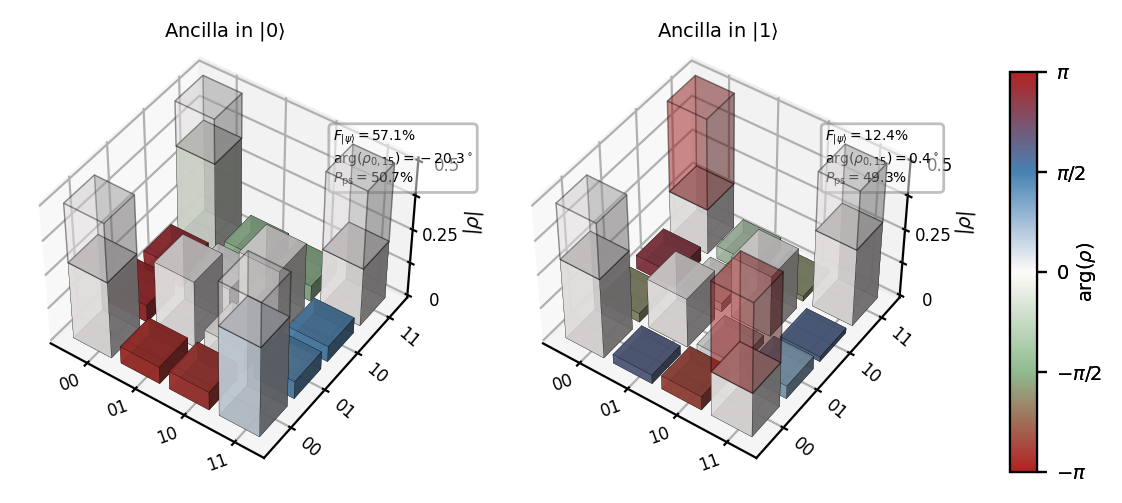

In [70]:
R_0 = np.zeros(rho_0.shape)
R_0[ 0, 0] = 0.5
R_0[ 0,-1] = 0.5
R_0[-1, 0] = 0.5
R_0[-1,-1] = 0.5

R_1 = np.zeros(rho_1.shape)
R_1[ 0, 0] = 0.5
R_1[ 0,-1] = -0.5
R_1[-1, 0] = -0.5
R_1[-1,-1] = 0.5

fid_0 = fidelity(rho_0, R_0)
fid_1 = fidelity(rho_1, R_1)
angle_0 = np.angle(rho_0[0,-1])*180/np.pi
angle_1 = np.angle(rho_1[0,-1])*180/np.pi
ps_frac_0 = np.mean(list(P_frac_0.values()))
ps_frac_1 = np.mean(list(P_frac_1.values()))
n_shots = len(tomo_shots_dict[1]['ZZ'])
print(fid_0, fid_1, angle_0, angle_1, ps_frac_0, ps_frac_1)

fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=45)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=45)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_1, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
# fig.savefig(DATA_DIR + filename, format='png', dpi=200)

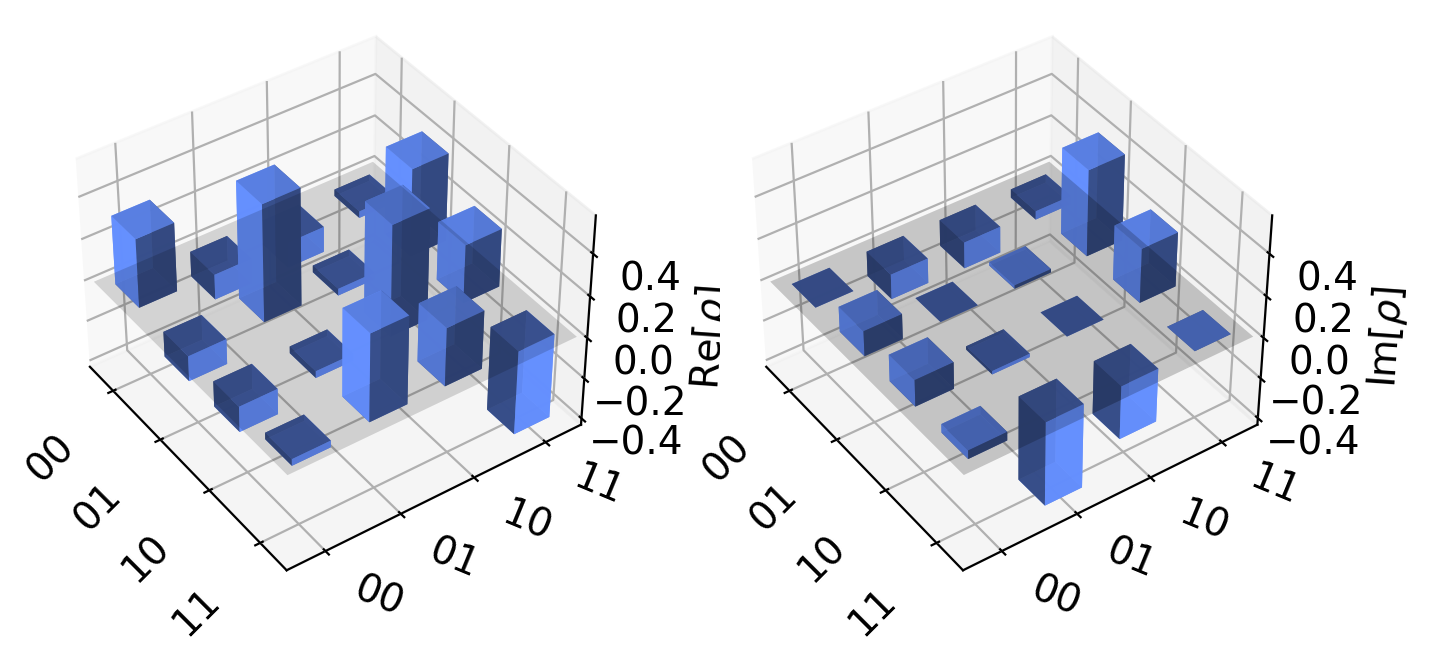

In [69]:
fig = plt.figure(figsize=(8, 8), dpi=200)
ax1 = fig.add_subplot(121, projection='3d', azim=-35, elev=40)
ax2 = fig.add_subplot(122, projection='3d', azim=-35, elev=40)
qvis.plot_state_city(rho_0, alpha=0.9, ax_real=ax1, ax_imag=ax2)
filename = exp_name + "_sim-msmt" + "_PLOT2.png" if sim_msmt else exp_name + "_PLOT2.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

# Testing

In [75]:
qubits = [1,2,3]
data_hex = np.loadtxt(DATA_DIR + "entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('Z', 'Z')_RAW.csv", comments='#', dtype='<U3', delimiter=',')

# data_bin = np.array(["{0:05b}".format(b) for b in list(map(lambda d: int(d, 16), data_hex.flatten()))]).reshape(data_hex.shape) #int(data_hex, 16))
# np.apply_over_axes(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex, data_hex.shape)
data_bin = np.array(list(map(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex.flatten()))).reshape(data_hex.shape)
# np.take(data_bin[1,0], qubits)
np.fromstring(data_bin[0,0])

/tmp/ipykernel_8820/1087478125.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(data_bin[0,0])


ValueError: string size must be a multiple of element size

In [7]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]"
results = get_json_data(exp_name + "_PROB.json")
results

[{'00000': 0.204345703125,
  '00010': 0.09130859375,
  '00100': 0.19244384765625,
  '00110': 0.09600830078125,
  '01000': 0.05621337890625,
  '01010': 0.14300537109375,
  '01100': 0.06707763671875,
  '01110': 0.14959716796875}]

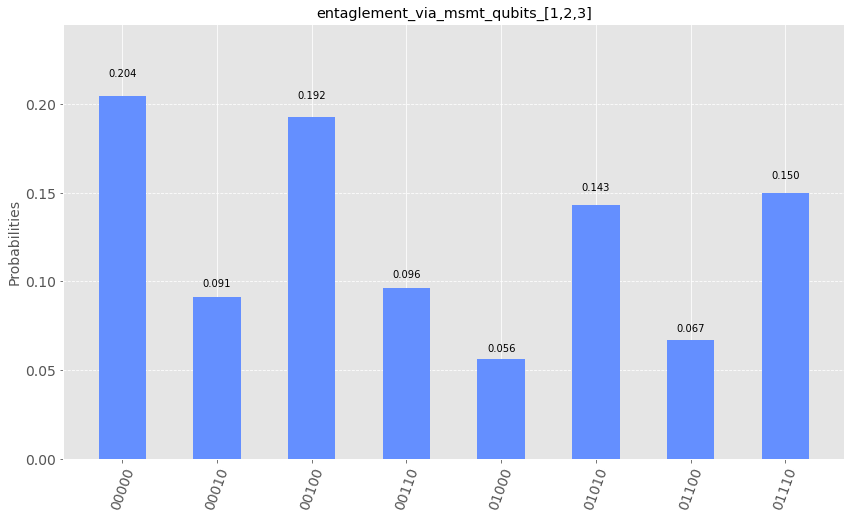

In [16]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))


In [17]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]_with_IDs"
results = get_json_data(exp_name + "_PROB.json")
results


[{'00000': 0.21929931640625,
  '00010': 0.09002685546875,
  '00100': 0.20880126953125,
  '00110': 0.09588623046875,
  '01000': 0.06439208984375,
  '01010': 0.11749267578125,
  '01100': 0.073974609375,
  '01110': 0.130126953125}]

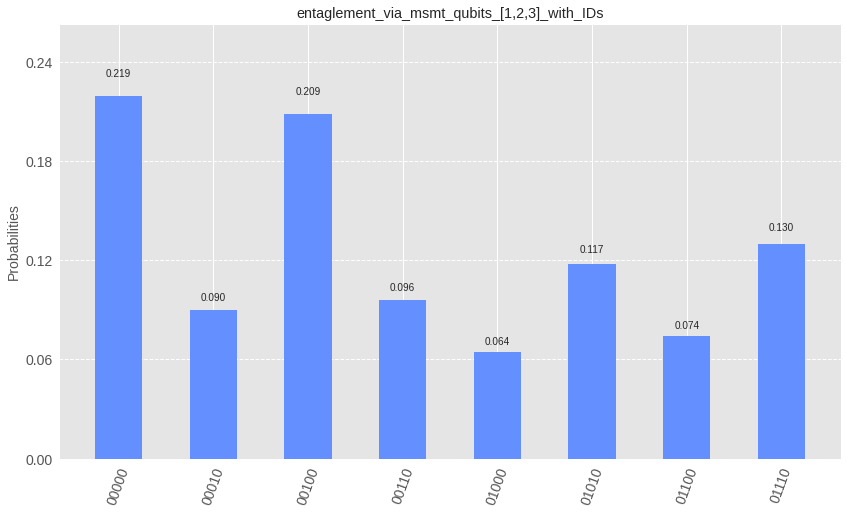

In [26]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))
